# Overview

This notebook imports raw ws3 input data, reformats and monkey-patches the data, and exports Woodstock formatted input data files (which we will use in other DSS notebooks for this case as the input data files). 

# Set up environment

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import ws3.forest, ws3.core
import csv
import numpy as np
from util import schedule_harvest_areacontrol, schedule_harvest_areacontrol_asap, schedule_harvest_areacontrol_null

Define some key model parameters (will get used but defined here up top for convenience).

In [35]:
period_length = 10
max_age =  1000

# Import and reformat inventory and yield input data

Read forest inventory data into memory (vector polygon GIS data layer with attribute table, in ESRI Shapefile format). This dataset represents a small subset of timber supply area (TSA) 22 in British Columbia. We monkey-patch the inventory data here to make it line up nicely with what we need downstream as input for the ws3 model (i.e., changes we make here to the in-memory dataset are not saved to the original dataset on disk). Most of what we are doing here is setting up the _theme_ columns in the attribute table, which should help newer ws3 users make the connection between input data and the landscape themes in ws3 model further down.

In [36]:
stands = gpd.read_file('data/tsa22_subset/stands.shp')
stands = stands.rename(columns={'thlb':'theme1', 'au':'theme2', 'ldspp':'theme3', 'age2015':'age', 'shape_area':'area' })
stands['area'] = stands.geometry.area * 0.0001 # monkey-patch broken area attribute
stands.insert(4, 'theme4', stands['theme2'])
stands['theme2'] = stands['theme2'].astype(int)

Read yield data from a CSV file and recast AU column data type to integer.

In [37]:
yld = pd.read_csv('data/yld.csv')
yld['AU'] = yld['AU'].astype(int)

Create analysis unit (AU) dataframe from stands dataframe data.

In [38]:
AU = pd.DataFrame(stands['theme2']).drop_duplicates()
AU.rename(columns={'theme2':'AU'}, inplace=True)

Join `AU` and `yld` dataframes.

In [39]:
yldmerged = pd.merge(AU, yld, on=['AU'], how='inner')

Import CANFI tree species lookup table (associates tree species names with integer numerical values, which we use as theme data values in the ws3 model), and insert species code values into the yield curve dataframe.

In [40]:
canf = pd.read_csv('data/canfi_species_modified.csv')
canf = canf[['name', 'canfi_species']].set_index('name')

Burn CANFI species codes into stand and yield data tables.

In [41]:
stands['theme3'] = stands.apply(lambda row: canf.loc[row['theme3'], 'canfi_species'], axis=1) 
yldmerged['canfi_species'] = yldmerged.apply(lambda row: canf.loc[row['LDSPP'], 'canfi_species'], axis=1)

Add a new `curve_id` colume that has same data values as `AU` column.

In [42]:
yldmerged['curve_id'] = yldmerged['AU'] 

Save reformatted data to CSV files. 

In [43]:
yldmerged.to_csv('data/yldmerged.csv', header=True, index=False)
stands.to_csv('data/stands_table.csv', header=True, index=False)

Rename stuff to match variable names we expect further down.

In [44]:
stands_table = stands
curve_points_table = yldmerged
curve_points_table.set_index('AU', inplace=True)

## LANDSCAPE section

The LANDSCAPE section defines stratification variables (themes) and stratification variable values (basecodes). 

In [53]:
theme_cols=['theme0', # TSA 
            'theme1', # THLB
            'theme2', # AU
            'theme3', # leading species code
            'theme4'  # yield curve ID
           ]
basecodes = [list(map(lambda x: str(x), stands_table[tc].unique())) for tc in theme_cols]
basecodes[2] = list(set(basecodes[2] + list(stands_table['theme2'].astype(str))))
basecodes[3] = list(set(basecodes[3] + list(stands_table['theme3'].astype(str))))
basecodes[4] = list(set(basecodes[4] + list(stands_table['theme4'].astype(str))))

In [54]:
with open('data/woodstock_model_files/tsa22.lan', 'w') as file:
    print('*THEME Timber Supply Area (TSA)', file=file)
    print('tsa17',file=file)
    print('*THEME Timber Harvesting Land Base (THLB)', file=file)
    for basecode in basecodes[1]: print(basecode, file=file)
    print('*THEME Analysis Unit (AU)', file=file)
    for basecode in basecodes[2]: print(basecode, file=file)
    print('*THEME Leading tree species (CANFI species code)', file=file)
    for basecode in basecodes[3]: print(basecode, file=file)
    print('*THEME Yield curve ID', file=file)
    for basecode in basecodes[4]: print(basecode, file=file)

## AREAS section

The AREAS section defines the initial forest inventory, in terms of how many hectares of which age class are present in which development type (where a development type is defined as a unique sequence of landscape theme variable values).

In [55]:
gstands = stands_table.groupby(theme_cols+['age'])

In [56]:
with open('data/woodstock_model_files/tsa22.are', 'w') as file:
    for name, group in gstands:
        dtk, age, area = tuple(map(lambda x: str(x), name[:-1])), int(name[-1]), group['area'].sum()
        print('*A', ' '.join(v for v in dtk), age, area, file=file)

## YIELDS section

The YIELDS section defines yield curves (in this example we only track merchantable log volume, but we can use yield curves to track all sorts of other stuff). 

In [57]:
with open('data/woodstock_model_files/tsa22.yld', 'w') as file:
        tot=[]
        swd=[]
        hwd=[]
        for AU, au_row in curve_points_table.iterrows():
            yname = 's%04d' % int(au_row.canfi_species)    
            curve_id = au_row.curve_id
            mask = ('?', '?', str(AU), '?', str(curve_id))
            points = [(x*10, au_row['X%i' % (x*10)]) for x in range(36)]
            c = ws3.core.Curve(yname, points=points, type='a', is_volume=True, xmax=max_age, period_length=period_length)
            print('*Y', ' '.join(v for v in mask), file=file)
            print(yname, '1', ' '.join(str(int(c[x])) for x in range(0, 350, 10)), file=file)
            if yname not in tot:
                tot.append(yname)
            if int(au_row.canfi_species) > 1200:
                if yname not in hwd: hwd.append(yname)
            else:
                if yname not in swd: swd.append(yname)
        print('*YC ? ? ? ? ?', file=file)
        print('totvol _SUM(%s)' % ', '.join(map(str, tot)), file=file)
        print('swdvol _SUM(%s)' % ', '.join(map(str, swd)), file=file)
        print('hwdvol _SUM(%s)' % ', '.join(map(str, hwd)), file=file)

## ACTIONS section

The ACTIONS section defines actions that can be applied in the model (e.g., harvesting, planting, thinning, fertilization, etc). 

In [58]:
with open('data/woodstock_model_files/tsa22.act', 'w') as file:
    print('ACTIONS', file=file)
    print('*ACTION harvest Y', file=file)
    print('*OPERABLE harvest', file=file)
    print('? 1 ? ? ? _AGE >= 90 AND _AGE <= 600', file=file)

## TRANSITIONS section

The TRANSITIONS section defines transitions (i.e., transition to a new development type and age class induced by applying a specific action to a specific combination of development type and age class). If there were no transitions in a forest estate model, it would simply be aging (i.e., growing) the forest forward from time step 1 through to time step N.

In [59]:
with open('data/woodstock_model_files/tsa22.trn', 'w') as file:
    acode = 'harvest'
    print('*CASE', acode, file=file)
    record_au = set()
    for au_id, au_row in stands_table.iterrows():
        if au_row.theme2 in record_au: continue
        if not au_row.theme1: continue
        target_curve_id = au_row.theme4  
        smask = ' '.join(('?', '?' , str(target_curve_id), '?', '?'))
        tmask = ' '.join(('?', '?' , '?', '?', str(target_curve_id)))
        print('*SOURCE', smask, file=file)
        print('*TARGET', tmask, '100', file=file)
        record_au.add(au_row.theme2)

# Export Woodstock-formatted input files 

We can use the new ws3 model instance we just built to export ws3 input files in Woodstock file format. We do this for three reasons. 

The first reason is that it will be simpler and more compact in the actual DSS notebook to instantiate the `ForestModel` object from these Woodstock-formatted files (and also this will provide an opportunity to demonstrate the existance and usage of the Woodstock model import functions that are built into ws3). 

The second reason is that the process of exporting data from a live `ws3.forest.ForestModel` instance to Woodstock-formatted input data files provides some insight into the internal structure and workings of ws3 models (which can be a challenging thing to get started with, particularly if you do not have a lot of experience building and running forest estate models). 

The third reason is that Woodstock file format is designed to be "human readable" (sort of... nobody ever said it would be super easy or super fun). Picking through the exported Woodstock-formatted files might help some people better understand the structure and details of the model we have built. If you have no experience reading Woodstock-formatted model input data files, then this is going to be trickier (unless you pause here and go take an introductory Woodstock training course of sort). Many forest professionals already have familiarity with Woodstock software and its special file format (through having been exposed to this at some point in their career). 

Start by creating a new subdirectory to hold the new Woodstock-formatted data files.

In [13]:
!mkdir data/woodstock_model_files

mkdir: cannot create directory ‘data/woodstock_model_files’: File exists


## LANDSCAPE section

The LANDSCAPE section defines stratification variables (themes) and stratification variable values (basecodes). 

In [14]:
theme_cols=['theme0', # TSA 
            'theme1', # THLB
            'theme2', # AU
            'theme3', # leading species code
            'theme4'  # yield curve ID
           ]
basecodes = [list(map(lambda x: str(x), stands_table[tc].unique())) for tc in theme_cols]
basecodes[2] = list(set(basecodes[2] + list(stands_table['theme2'].astype(str))))
basecodes[3] = list(set(basecodes[3] + list(stands_table['theme3'].astype(str))))
basecodes[4] = list(set(basecodes[4] + list(stands_table['theme4'].astype(str))))

In [15]:
with open('data/woodstock_model_files/tsa17.lan', 'w') as file:
    print('*THEME Timber Supply Area (TSA)', file=file)
    print('tsa17',file=file)
    print('*THEME Timber Harvesting Land Base (THLB)', file=file)
    for basecode in basecodes[1]: print(basecode, file=file)
    print('*THEME Analysis Unit (AU)', file=file)
    for basecode in basecodes[2]: print(basecode, file=file)
    print('*THEME Leading tree species (CANFI species code)', file=file)
    for basecode in basecodes[3]: print(basecode, file=file)
    print('*THEME Yield curve ID', file=file)
    for basecode in basecodes[4]: print(basecode, file=file)

## AREAS section

The AREAS section defines the initial forest inventory, in terms of how many hectares of which age class are present in which development type (where a development type is defined as a unique sequence of landscape theme variable values).

In [16]:
gstands = stands_table.groupby(theme_cols+['age'])

In [17]:
with open('data/woodstock_model_files/tsa17.are', 'w') as file:
    for name, group in gstands:
        dtk, age, area = tuple(map(lambda x: str(x), name[:-1])), int(name[-1]), group['area'].sum()
        print('*A', ' '.join(v for v in dtk), age, area, file=file)

## YIELDS section

The YIELDS section defines yield curves (in this example we only track merchantable log volume, but we can use yield curves to track all sorts of other stuff). 

In [25]:
with open('data/woodstock_model_files/tsa17.yld', 'w') as file:
        tot=[]
        swd=[]
        hwd=[]
        for AU, au_row in curve_points_table.iterrows():
            yname = 's%04d' % int(au_row.canfi_species)    
            curve_id = au_row.curve_id
            mask = ('?', '?', str(AU), '?', str(curve_id))
            points = [(x*10, au_row['X%i' % (x*10)]) for x in range(36)]
            c = ws3.core.Curve(yname, points=points, type='a', is_volume=True, xmax=max_age, period_length=period_length)
            print('*Y', ' '.join(v for v in mask), file=file)
            print(yname, '1', ' '.join(str(int(c[x])) for x in range(0, 350, 10)), file=file)
            if yname not in tot:
                tot.append(yname)
            if int(au_row.canfi_species) > 1200:
                if yname not in hwd: hwd.append(yname)
            else:
                if yname not in swd: swd.append(yname)
        print('*YC ? ? ? ? ?', file=file)
        print('totvol _SUM(%s)' % ', '.join(map(str, tot)), file=file)
        print('swdvol _SUM(%s)' % ', '.join(map(str, swd)), file=file)
        print('hwdvol _SUM(%s)' % ', '.join(map(str, hwd)), file=file)

## ACTIONS section

The ACTIONS section defines actions that can be applied in the model (e.g., harvesting, planting, thinning, fertilization, etc). 

In [19]:
with open('data/woodstock_model_files/tsa17.act', 'w') as file:
    print('ACTIONS', file=file)
    print('*ACTION harvest Y', file=file)
    print('*OPERABLE harvest', file=file)
    print('? 1 ? ? ? _AGE >= 90 AND _AGE <= 600', file=file)

## TRANSITIONS section

The TRANSITIONS section defines transitions (i.e., transition to a new development type and age class induced by applying a specific action to a specific combination of development type and age class). If there were no transitions in a forest estate model, it would simply be aging (i.e., growing) the forest forward from time step 1 through to time step N.

In [20]:
with open('data/woodstock_model_files/tsa17.trn', 'w') as file:
    acode = 'harvest'
    print('*CASE', acode, file=file)
    record_au = set()
    for au_id, au_row in stands_table.iterrows():
        if au_row.theme2 in record_au: continue
        if not au_row.theme1: continue
        target_curve_id = au_row.theme4  
        smask = ' '.join(('?', '?' , str(target_curve_id), '?', '?'))
        tmask = ' '.join(('?', '?' , '?', '?', str(target_curve_id)))
        print('*SOURCE', smask, file=file)
        print('*TARGET', tmask, '100', file=file)
        record_au.add(au_row.theme2)

In [4]:
# Reading stands file
stands = gpd.read_file('data/tsa22.shp/stands selection.shp') #ECCC TSA 22

In [5]:
stands = stands.rename(columns={'thlb': 'theme1', 'au': 'theme2', 'ldspp': 'theme3', 'age2015': 'age', 'shape_area': 'area' })

In [6]:
# Fixing areas using geometry data (initially all areas were zero)
stands['area'] = stands.geometry.area*0.0001


In [7]:
# Adding theme 4 (which is curve_id) to the stands table
stands.insert(4, 'theme4', stands['theme2'])

##### Modified for TSA 22 (ECCC projetc) to extract the unique AU from yld.csv file 

In [8]:
# This code changes the type of "theme2" into integer
stands['theme2'] = stands['theme2'].astype(int)

In [9]:
# Reading yld table and changing AU column type into integer
yld = pd.read_csv('data/yld.csv')
yld['AU'] = yld['AU'].astype(int)

In [10]:
# Creating AU table from stands table and renaming the column to AU. The AU table is then joined with yld table.
AU = pd.DataFrame(stands['theme2']).drop_duplicates()
AU.rename(columns = {'theme2':'AU'},inplace=True)

In [11]:
# Inner joining AU and yld tables. The results of the code will be a yield table (yldmerged) that has AU column.
yldmerged = pd.merge(AU, yld, on=['AU'], how='inner')

In [12]:
# Getting names and codes of canfi_species. This table will be used to add canfi_species column into yldmerged
canf = pd.read_csv('data/canfi_species_modified.csv')
canf = canf[['name','canfi_species']].set_index('name')

In [13]:
# Adding codes of leading species under canfi_species in the yldmerged
for index, row in yldmerged.iterrows():
    yldmerged.at[index,'canfi_species'] = canf.loc[row['LDSPP'],'canfi_species']  

In [14]:
# once the modifications are done, the yldmerged table is converted into csv file in a directory path defined by the user. Later, this file will be used to read curve_points_table
output_csv_path = 'data/yldmerged.csv'
yldmerged.to_csv(output_csv_path, header=True, index=False)

##### End of modification 

In [15]:
# converting stands to csv file, and reading stands_table from the csv file
output_stand_csv_path = 'data/stands_table.csv'
stands_table = stands.to_csv(output_stand_csv_path, header=True, index=False)
stands_table = pd.read_csv('data/stands_table.csv')


In [16]:
# replacing leading species names with their codes
for index, row in stands_table.iterrows():
    stands_table.at[index,'theme5'] = canf.loc[row['theme3'],'canfi_species']
stands_table['theme3'] = stands_table['theme5']
stands_table = stands_table.drop('theme5',axis=1)

In [17]:
stands_table['theme3'] = stands_table['theme3'] .astype(int)

In [18]:
# Reading curve_points_table
curve_points_table = pd.read_csv('data/yldmerged.csv')

In [19]:
# Adding 'curve_id' and 'canfi_species' columns to curve_points_table
curve_points_table ['curve_id'] = curve_points_table ['AU'] 
curve_points_table ['canfi_species'] = yldmerged ['canfi_species']

In [20]:
# converting curve_points_table to csv file
output_curve_points_csv_path = 'data/curve_points_table.csv'
curve_points_table.to_csv(output_curve_points_csv_path, header=True, index=False)

In [21]:
# Reading curve_points_table from the csv file and settign AU as the index
columns_to_index_yld = ['AU']
curve_points_table = pd.read_csv('data/curve_points_table.csv').set_index(columns_to_index_yld)

In [22]:
# Setting up themes
theme_cols=['theme0', # TSA 
            'theme1', # THLB
            'theme2', # AU
            'theme3', # leading species code
            'theme4'  # yield curve ID
           ]
basecodes = [list(map(lambda x: str(x), stands_table[tc].unique())) for tc in theme_cols]

In [23]:
# also scrape au_table for AU and curve ID values that are not in inventory but might pop up later (hack?)
basecodes[2] = list(set(basecodes[2] + list(stands_table['theme2'].astype(str))))
basecodes[3] = list(set(basecodes[3] + list(stands_table['theme3'].astype(str))))
basecodes[4] = list(set(basecodes[4] + list(stands_table['theme4'].astype(str))))

In [24]:
# Building the forest model
fm = ws3.forest.ForestModel(model_name='tsa22',
                            model_path='data',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)

In [25]:
# Set up themes
for ti, t in enumerate(theme_cols):
    fm.add_theme(t, basecodes[ti])
# fm.nthemes = len(theme_cols)

In [26]:
# Aggregating inventory data
gstands = stands_table.groupby(theme_cols+['age'])

In [27]:
# Loading areas from inventory
age_cutoff = 600

for name, group in gstands:
    dtk, age, area = tuple(map(lambda x: str(x), name[:-1])), int(name[-1]), group['area'].sum()
    if dtk not in fm.dtypes:
        fm.dtypes[dtk] = ws3.forest.DevelopmentType(dtk, fm)
    age = age if age < age_cutoff else age_cutoff
    fm.dtypes[dtk].area(0, age, area)
    # fm.dtypes[dtk].last_pass_disturbance = 'fire' if age > 60 else 'harvest'

In [28]:
# Reading points_table which was created in csv file in order to convert to a 2-column table (x,y)
points_table = pd.read_csv('data/points_table.csv').set_index('AU')

In [29]:
# Reading and registering curve points
for AU, au_row in curve_points_table.iterrows():
    yname = 's%04d' % int(au_row.canfi_species)    
    curve_id = au_row.curve_id
    mask = ('?', '?', str(AU), '?', str(curve_id))
    points = [(r.x, r.y) for _, r in points_table.loc[AU].iterrows() if not r.x % period_length and r.x <= max_age]    
    c = fm.register_curve(ws3.core.Curve(yname, points=points, type='a', is_volume=True, xmax=fm.max_age, period_length=period_length))
    fm.yields.append((mask, 'a', [(yname, c)])) # only if not already present?
    fm.ynames.add(yname)        
    for dtk in fm.unmask(mask): 
        fm.dtypes[dtk].add_ycomp('a', yname, c)

In [30]:
# Add total volume curves
expr = '_SUM(%s)' % ', '.join(fm.ynames)
fm.yields.append((('?', '?', '?', '?', '?'), 'c', [(tvy_name, expr)]))
fm.ynames.add(tvy_name)
for dtk in fm.dtypes.keys(): fm.dtypes[dtk].add_ycomp('c', tvy_name, expr)  

In [31]:
# Setting up an action
acode = 'fire'
oe = '_age >= 50 and _age <= 600' # operability expression
fm.transitions[acode] = {}
for au_id, au_row in stands_table.iterrows():
    # if not au_row.theme1: continue
    target_curve_id = au_row.theme4  
    smask = ('?', '?' , str (target_curve_id), '?', '?')
    tmask = ('?', '?' , '?', '?', str(target_curve_id) ) 
    target = [(tmask, 1.0, None, None, None, None, None)] # list of one (single target... not modelling "divergent" transitions)
    fm.actions[acode] = ws3.forest.Action(acode, targetage=0, is_harvest=False)
    fm.oper_expr[acode] = {smask:oe}        
    fm.transitions[acode].update({smask:{'':target}}) # the '' is a blank source condition expression
    for dtk in fm.unmask(smask):
        dt = fm.dtypes[dtk]
        dt.oper_expr[acode] = [oe]
        for age in range(1, fm.max_age):
            if not dt.is_operable(acode, 1, age): continue          
            fm.dtypes[dtk].transitions[acode, age] = target

In [32]:
fm.compile_actions()

# Poking around the model

(0.0, 350.0)

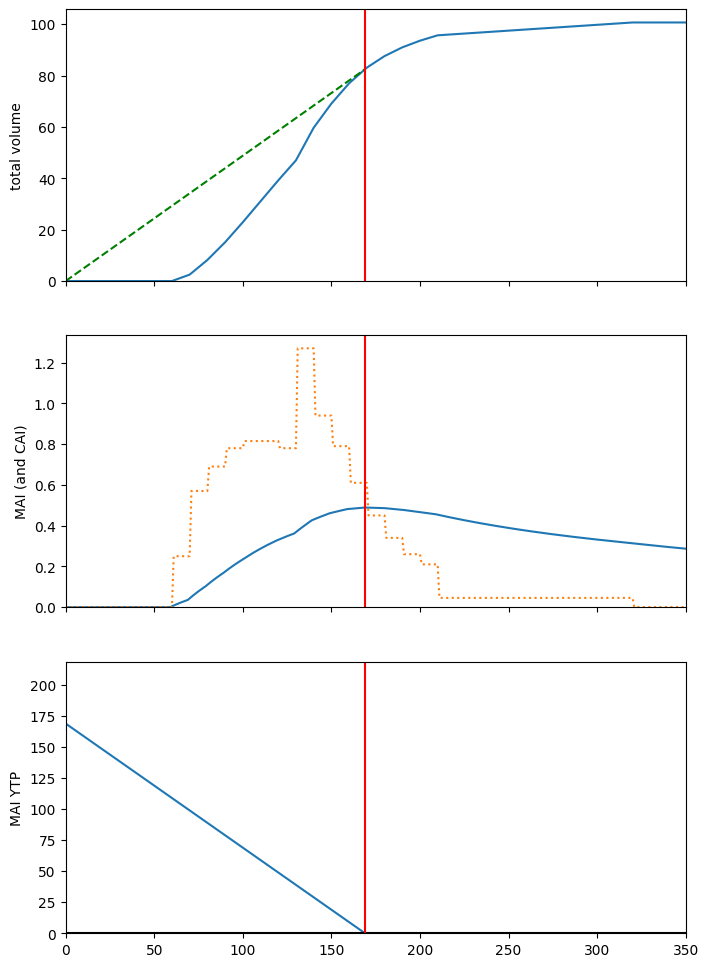

In [33]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

cvol = c
ccai = c.cai()
cmai = c.mai()
cmaiytp = c.mai().ytp()
x_cmai = cmaiytp.lookup(0) # optimal rotation age (i.e., culmination of MAI curve)
labels = 'total volume', 'MAI (and CAI)', 'MAI YTP'

ax[0].plot(*zip(*c.points()))
ax[0].plot([0, x_cmai], [0., cvol[x_cmai]], linestyle='--', color='green')

ax[1].plot(*zip(*c.mai().points()))
ax[1].plot(*zip(*c.cai().points()), linestyle=':')

ax[2].plot(*zip(*c.mai().ytp().points()))
ax[2].axhline(0, color='black')

for i in range(len(ax)):
    ax[i].set_ylabel(labels[i])
    ax[i].set_ylim(0, None)
    ax[i].axvline(x_cmai, color='red')
plt.xlim(0, 350)

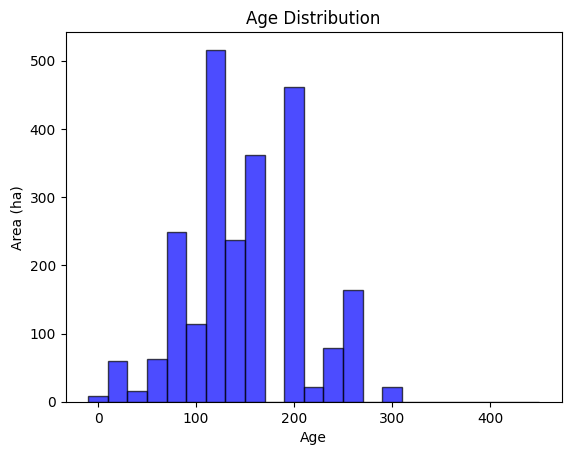

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming fm.age_class_distribution(0) returns a dictionary or two lists (x and y)
data = fm.age_class_distribution(0)

# Extracting x and y values
x_values = list(data.keys())
y_values = list(data.values()) 

# Define custom bin edges
bin_edges = np.arange(0, 480, 20)

# Create a histogram using numpy.histogram()
hist, _ = np.histogram(x_values, bins=bin_edges, weights=y_values)

# Plot the histogram
plt.bar(bin_edges[:-1], hist, width=20, color='blue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Area (ha)')
plt.title('Age Distribution')

# Show the plot
plt.show()


# Implement a priority queue harvest scheduling heuristic


In [35]:
fm.reset()

In [36]:
fm.areaselector = RandomAreaSelector(fm)

In [37]:
verbose = False # flip to True if you want the harvest scheduler to get _really_ chatty while it works
for period in fm.periods:
    schedule_fire_areacontrol(fm, period=period, verbose=verbose, intensity = intensity ) #Equivalent Scenario

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'Burned area (ha)'}>,
        <Axes: title={'center': 'Burned volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>], dtype=object))

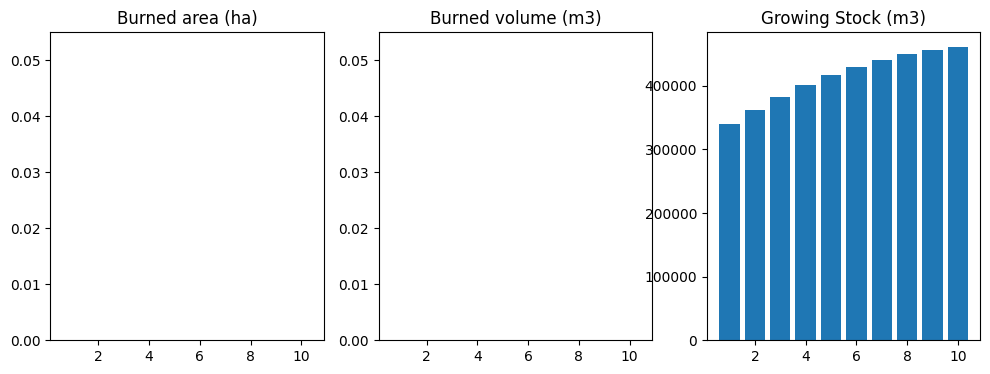

In [38]:
df = compile_scenario(fm)
plot_scenario(df)
# plot_results(fm)

In [39]:
pareas = [fm.compile_product(period, '1.') for period in fm.periods]

In [40]:
pvols = [fm.compile_product(period, 'totvol') for period in fm.periods]

In [41]:
df = pd.DataFrame({'period':fm.periods, 'areas':pareas, 'vols':pvols})

In [42]:
!mkdir data/woodstock_model_files

mkdir: cannot create directory ‘data/woodstock_model_files’: File exists


# LANDSCAPE section

In [43]:
with open('data/woodstock_model_files/tsa22.lan', 'w') as file:
    print('*THEME Timber Supply Area (TSA)',file=file)
    print('tsa22',file=file)
    print('*THEME Timber Harvesting Land Base (THLB)',file=file)
    for w in fm._theme_basecodes[1]: print(w,file=file)
    print('*THEME Analysis Unit (AU)',file=file)
    for x in fm._theme_basecodes[2]: print(x,file=file)
    print('*THEME Leading tree species (CANFI species code)',file=file)
    for y in fm._theme_basecodes[3]: print(y,file=file)
    print('*THEME Yield curve ID',file=file)
    for z in fm._theme_basecodes[4]: print(z,file=file)

# AREAS section

In [44]:
with open('data/woodstock_model_files/tsa22.are', 'w') as f:
    for name, group in gstands:
        dtk, age, area = tuple(map(lambda x: str(x), name[:-1])), int(name[-1]), group['area'].sum()
        print('*A', ' '.join(v for v in dtk), age, area, file=f)

# `YIELDS` section

In [45]:
with open('data/woodstock_model_files/tsa22.yld', 'w') as file:
        tot=[]
        swd=[]
        hwd=[]
        for AU, au_row in curve_points_table.iterrows():
            
            yname = 's%04d' % int(au_row.canfi_species)    
            curve_id = au_row.curve_id
            mask = ('?', '?', str(AU), '?', str(curve_id))
            points = [(r.x, r.y) for _, r in points_table.loc[AU].iterrows() if not r.x % period_length and r.x <= max_age]    
            c = fm.register_curve(ws3.core.Curve(yname, points=points, type='a', is_volume=True, xmax=fm.max_age, period_length=period_length))
            print('*Y', ' '.join(v for v in mask), file=file)
            print(yname, '1', ' '.join(str(int(c[x])) for x in range(0, 350, 10)), file=file)
            if yname not in tot:
                tot.append(yname)
            if int(au_row.canfi_species) >1200:
                if yname not in hwd:
                    hwd.append(yname)
            else:
                if yname not in swd:
                    swd.append(yname)
        print('*YC ? ? ? ? ?',file=file)
        print('totvol _SUM(%s)'%', '.join(map(str, tot)),file=file)
        print('swdvol _SUM(%s)'%', '.join(map(str, swd)),file=file)
        print('hwdvol _SUM(%s)'%', '.join(map(str, hwd)),file=file)


# `ACTIONS` section

In [46]:
with open('data/woodstock_model_files/tsa22.act', 'w') as file:
    print('ACTIONS', file=file)
    print('*ACTION fire Y', file=file)
    print('*OPERABLE fire', file=file)
    print('? ? ? ? ? _AGE >= 50 AND _AGE <= 600', file=file)

# `TRANSITIONS` section

In [47]:
# Setting up an action
with open('data/woodstock_model_files/tsa22.trn', 'w') as file:
    acode = 'fire'
    print('*CASE', acode, file=file)
    record_au = set()
    for au_id, au_row in stands_table.iterrows():
        if au_row.theme2 in record_au: continue
        # if not au_row.theme1: continue
        target_curve_id = au_row.theme4  
        smask = ' '.join(('?', '?' , str (target_curve_id), '?', '?'))
        tmask = ' '.join(('?', '?' , '?', '?', str(target_curve_id)))
        print('*SOURCE', smask, file=file)
        print('*TARGET', tmask, '100', file=file)
        record_au.add(au_row.theme2)